In [37]:
#import video from test.mp4

import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import matplotlib.image as mpimg
target_size = (640, 480)



In [38]:
def calc_flow(img1,img2):
    return cv2.calcOpticalFlowFarneback(prev=img1, 
                                    next=img2, 
                                    flow=None,
                                    pyr_scale=0.5, 
                                    levels=3, 
                                    winsize=15,
                                    iterations=3, 
                                    poly_n=5, 
                                    poly_sigma=1.2, 
                                    flags=0)

In [39]:
working_dir = os.path.curdir
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# you can find a pretrained model at model/b3.pth
MODEL_F = os.path.join(working_dir,'b0.pth')
# directory with the numpy optical flow images you want to use for inference
OF_NPY_DIR = os.path.join(working_dir, 'test_predictions')
model = EfficientNet.from_pretrained(f'efficientnet-b{0}', in_channels=2, num_classes=1)
state = torch.load(MODEL_F, map_location=device)
model.load_state_dict(state)
model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    2, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [40]:
def predict(img):
    img = torch.from_numpy(img).float().permute(2,0,1).unsqueeze(0).to(device)
    return model(img).item()

In [41]:
cap = cv2.VideoCapture('mcgill_drive.mp4')
#skip the first 100 frames
for i in range(30*15):
    cap.read()
prev_frame = cap.read()[1]
prev_frame = cv2.resize(prev_frame, target_size, interpolation = cv2.INTER_AREA)
prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
count = 0
output = []
while(cap.isOpened()):
    count += 1
    if count == 100:
        break
    ret, frame = cap.read()
    #calculate the flow
    if ret == True:
        frame = cv2.resize(frame, target_size, interpolation = cv2.INTER_AREA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = calc_flow(prev_frame,frame)
        speed = predict(flow)
        output.append(speed)
        prev_frame = frame
    else:
        break

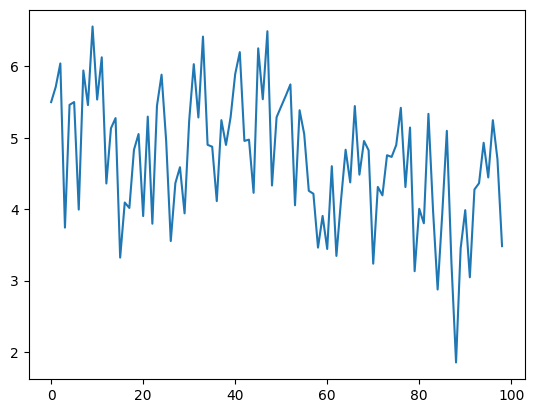

In [42]:
#plot the output
plt.plot(output)
plt.show(1)